# Pneumonia Detection from Chest X-Ray


- Dataset: [Chest-Xray-Pneumonia - Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).
- Reference: [anjanatiha jupyter notebook](https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning).




In [0]:
# Install Kaggle
! pip install -q kaggle

# import function to upload files (upload kaggle.json)
from google.colab import files

In [0]:
# Upload Kaggle key
files.upload()

In [0]:
# Create directory for kaggle.json
# Copy and Set permission
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:24<00:00, 93.4MB/s]
100% 2.29G/2.29G [00:24<00:00, 102MB/s] 


In [0]:
! unzip chest-xray-pneumonia.zip

### Import Libraries

In [0]:
! pip install --upgrade keras

     |████████████████████████████████| 378kB 2.9MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%tensorflow_version

TensorFlow 2.x selected.
Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys
import random
import time
import datetime
from collections import Counter
import numpy as np
import pandas as pd
import pathlib
import shutil
from tqdm import tqdm
import inspect
import gc
import re

from PIL import Image
import cv2

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

from tensorflow import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import img_to_array, array_to_img
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Flatten, BatchNormalization, Dense
from keras.layers import Input
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import maxnorm
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras import backend as K

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.


### Functions Declaration

In [0]:
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    K.clear_session()
    gc.collect()
    return True


def reset_callbacks(
        checkpoint=None, 
        reduce_lr=None, 
        early_stopping=None,
        tensorboard=None 
    ):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

In [0]:

def show_batch(image_batch, label_batch, title=""):
    fig = plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0])
        plt.axis('off')
    fig.suptitle(title)


def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(
            img, 
            (IMG_HEIGHT, IMG_WIDTH),
            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
        )

def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size=(IMG_HEIGHT, IMG_WIDTH, 3))
    return cropped_image

def random_jitter(img):
    # resizing to 286 x 286 x 3
    img = tf.image.resize(
        img,
        (286, 286),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    # randomly cropping to 256 x 256 x 3
    img = random_crop(img)
    # random mirroring
    img = tf.image.random_flip_left_right(img)
    return img

# normalizing the images to [-1, 1]
def normalize(img):
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1
    return img


def load_image_train(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    #img = random_jitter(img)
    #img = normalize(img)
    return img, label


def load_image_test(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    #img = normalize(img)
    return img, label



def plot_learning_curves(history):
    plt.figure(figsize=(12,4))

    xlabel = 'Epoch'    
    legends = ['Training', 'Validation']

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel(xlabel)
    plt.legend(legends, loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(legends, loc='upper left')
    
    plt.tight_layout()
    

def get_confusion_matrix(y_true, y_pred_classes, confusion_matrix_file, model_title):
    precision = precision_score(y_true, y_pred_classes) 
    recall = recall_score(y_true, y_pred_classes) 
    f1 = f1_score(y_true, y_pred_classes) 

    print("-"*90)
    print("Derived Report")
    print("-"*90)
    print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
    print("-"*90)
    print("\n\n")

    CM = confusion_matrix(y_true, y_pred_classes)

    classes = CLASS_NAMES

    fig, ax = plot_confusion_matrix(
                conf_mat    = CM ,  
                figsize     = (10,8), 
                hide_ticks  = True,
                cmap        = plt.cm.Blues
            )
    plt.xticks(range(len(classes)), classes, fontsize=12)
    plt.yticks(range(len(classes)), classes, fontsize=12)
    plt.title("Confusion Matrix for Model File (Test Dataset): \n"+best_model, fontsize=11)
    plt.show()
    fig.savefig(confusion_matrix_file, dpi=100)
    cls_report_print = classification_report(y_true, y_pred_classes, target_names=classes)
    cls_report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

    print("\n\n")
    print("-"*90)
    print("Report for Model File: ", model_title)
    print("-"*90)
    print(cls_report_print)
    print("-"*90)


### Preprocessing

In [0]:
reset_graph()
reset_callbacks()

In [0]:
# Initialize Variables

root_dir = "./"
dataset_root_dir = r"chest_xray/"

# Input dir
train_dir   = pathlib.Path(dataset_root_dir + r"train")
test_dir    = pathlib.Path(dataset_root_dir + r"test")
val_dir     = pathlib.Path(dataset_root_dir + r"val")

# Output dir
output_dir          = root_dir + r"data/output/"
output_figures_dir  = output_dir + "figures"

temp = root_dir
for d in output_figures_dir.split('/'):
    temp += d + "/"
    if not os.path.exists(temp):
        os.mkdir(temp)

# The 1./255 is to convert from uint8 to float32 in range [0,1].
RESCALE     = 1./255
BATCH_SIZE  = 64
IMG_HEIGHT  = 150
IMG_WIDTH   = 150
IMG_SHAPE   = (IMG_HEIGHT, IMG_WIDTH, 3)
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)
SHUFFLE_BUFFER_SIZE = 6000

train_data_count    = len(list(train_dir.glob('*/*.jpeg')))
test_data_count     = len(list(test_dir.glob('*/*.jpeg')))
val_data_count      = len(list(val_dir.glob('*/*.jpeg')))
TOTAL_IMAGE_COUNT         = train_data_count + test_data_count + val_data_count

STEPS_PER_EPOCH = np.ceil(TOTAL_IMAGE_COUNT/BATCH_SIZE)

In [0]:
# Training, Testing, Validation Data

print("Total images count       : ", TOTAL_IMAGE_COUNT)
print("Training data count      : ", train_data_count)
print("Testing data count       : ", test_data_count)
print("Validation data count    : ", val_data_count)

train_class_name    = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
test_class_name     = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
val_class_name      = np.array([item.name for item in val_dir.glob('*') if item.name != "LICENSE.txt"])

print("Training data classes    : ", train_class_name)
print("Testing data classes     : ", test_class_name)
print("Validation data classes  : ", val_class_name)

CLASS_NAMES = np.unique(train_class_name)
CLASS_COUNT = len(CLASS_NAMES)
CLASS_DICT  = {idx:key for idx, key in enumerate(CLASS_NAMES)}
print("Class names              : ", CLASS_NAMES)
print("Class dict               : ", CLASS_DICT)

Total images count       :  5856
Training data count      :  5216
Testing data count       :  624
Validation data count    :  16
Training data classes    :  ['PNEUMONIA' 'NORMAL']
Testing data classes     :  ['PNEUMONIA' 'NORMAL']
Validation data classes  :  ['PNEUMONIA' 'NORMAL']
Class names              :  ['NORMAL' 'PNEUMONIA']
Class dict               :  {0: 'NORMAL', 1: 'PNEUMONIA'}


In [0]:
# Load using tf.data
"""
The above keras.preprocessing method is convienient, but has two downsides:
    It's slow. 
    It lacks fine-grained control.
    It is not well integrated with the rest of TensorFlow.
"""

train_dir_ = str(train_dir/'*/*')
val_dir_ = str(val_dir/'*/*')
test_dir_ = str(test_dir/'*/*')

train_dataset = tf.data.Dataset.list_files(train_dir_)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.map(
        load_image_train, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.list_files(val_dir_)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(val_data_count)

test_dataset = tf.data.Dataset.list_files(test_dir_)
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(test_data_count)
train_dataset, val_dataset, test_dataset

(<DatasetV1Adapter shapes: ((None, 150, 150, 3), (None, 2)), types: (tf.float32, tf.bool)>,
 <DatasetV1Adapter shapes: ((None, 150, 150, 3), (None, 2)), types: (tf.float32, tf.bool)>,
 <DatasetV1Adapter shapes: ((None, 150, 150, 3), (None, 2)), types: (tf.float32, tf.bool)>)

### Image Processing, Augmentation, Transformation for Datasets

In [0]:
for image, label in train_dataset.take(1):
    print("Train Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
for image, label in val_dataset.take(1):
    print("Validation Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
for image, label in test_dataset.take(1):
    print("Test Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
del image, label

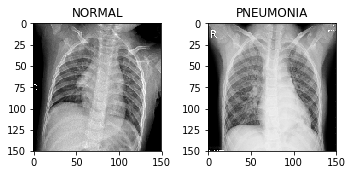

In [0]:
train_image_batch, train_label_batch = next(iter(train_dataset.take(5)))

plt.figure(figsize=(5, 3))

y_train_classes = np.argmax(train_label_batch, axis = 1)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(train_image_batch[np.argmax(y_train_classes == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(train_image_batch[np.argmax(y_train_classes == 1)])

plt.tight_layout()

del train_image_batch, train_label_batch, y_train_classes

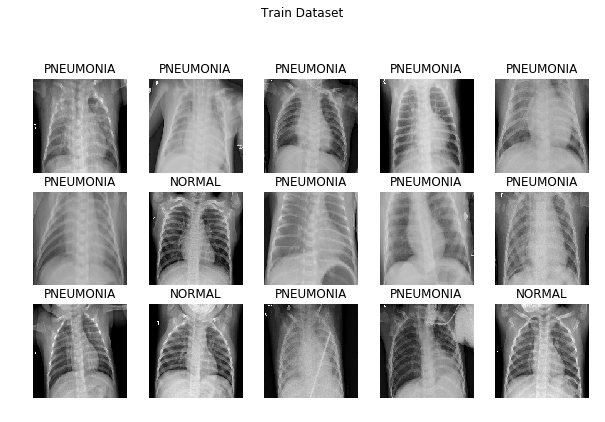

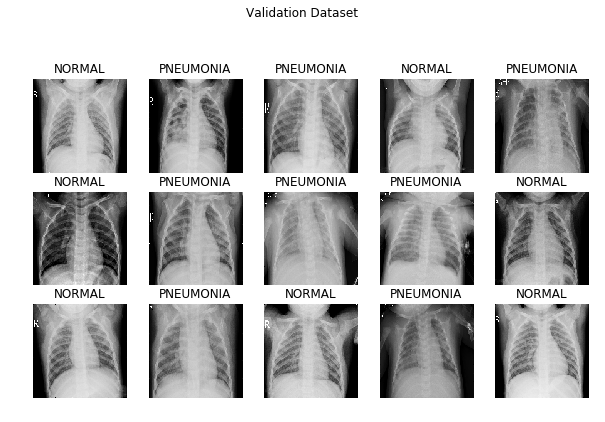

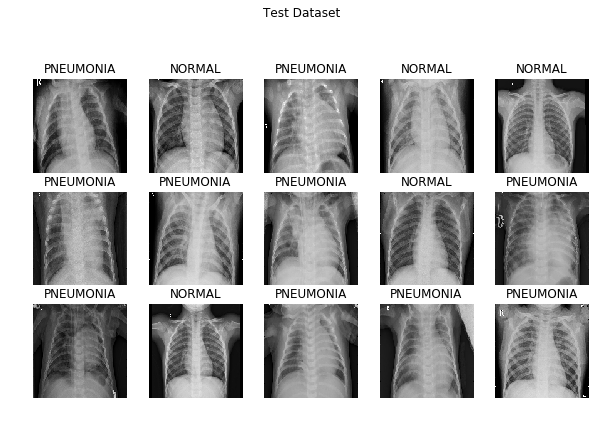

In [0]:
# Inspect a batch of data
train_image_batch, train_label_batch = next(iter(train_dataset.take(1)))
show_batch(train_image_batch.numpy(), train_label_batch.numpy(), "Train Dataset")

val_image_batch, val_label_batch = next(iter(val_dataset))
show_batch(val_image_batch.numpy(), val_label_batch.numpy(), "Validation Dataset")

test_image_batch, test_label_batch = next(iter(test_dataset))
show_batch(test_image_batch.numpy(), test_label_batch.numpy(), "Test Dataset")


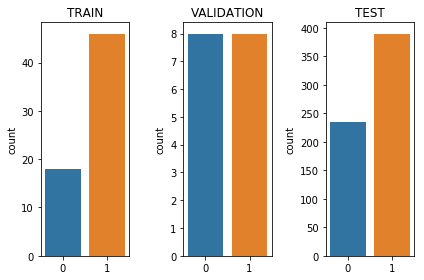

In [0]:
plt.subplot(1,3,1)
sns.countplot(np.argmax(train_label_batch.numpy(), axis=1)).set_title('TRAIN')

plt.subplot(1,3,2)
sns.countplot(np.argmax(val_label_batch.numpy(), axis=1)).set_title('VALIDATION')

plt.subplot(1,3,3)
sns.countplot(np.argmax(test_label_batch.numpy(), axis=1)).set_title('TEST')

plt.tight_layout()

### Training Files Configuration

In [0]:
# Use unix commands since it's easier
model_dir   = output_dir + r"models/"
log_dir     = output_dir + r"logs/"

if os.path.exists(model_dir):
    if len(os.listdir(model_dir)):
        ! rm -r {model_dir}*
else:
    ! mkdir {model_dir}

if os.path.exists(log_dir):
    if len(os.listdir(log_dir)):
        ! rm -r {log_dir}*
else:
    ! mkdir {log_dir}

curr_model_dir = model_dir + time.strftime('%Y-%m-%d_%H-%M-%S') + "/"
curr_log_dir = log_dir + time.strftime('%Y-%m-%d_%H-%M-%S')
print("Creating folders: ", curr_model_dir, curr_log_dir)

if os.path.exists(curr_model_dir):
    if len(os.listdir(curr_model_dir)):
        ! rm -r {curr_model_dir}*
else:
    ! mkdir {curr_model_dir}

if os.path.exists(curr_log_dir):
    if len(os.listdir(curr_log_dir)):
        ! rm -r {curr_log_dir}*
else:
    ! mkdir {curr_log_dir}
    

Creating folders:  ./data/output/models/2019-10-09_17-11-14/ ./data/output/logs/2019-10-09_17-11-14


### Callbacks

In [0]:
reset_graph()
reset_callbacks()

In [0]:
# https://keras.io/callbacks/

def get_callbacks(model_name=""):
    checkpoint = ModelCheckpoint(
            model_name, 
            monitor='val_loss', 
            save_best_only=True
        )

    early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            restore_best_weights=True
        )

    tensorboard = TensorBoard(
            log_dir=log_dir,
            update_freq = 'batch'
        )

    reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            patience=1,
            factor=0.2,
            min_lr=0.0000000001,
            verbose=1
        )

    return [checkpoint]#, reduce_lr, early_stopping, tensorboard]

model_name = curr_model_dir + "epoch_{epoch:02d}-val_loss_{val_loss:.2f}.hdf5"
callbacks = get_callbacks(model_name)

### Model Configurations using Pre-trained Models

In [0]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5
# https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network
# https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes

#InceptionV3 vgg16
pretrained_model = tf.keras.applications.vgg16.VGG16(
        weights='imagenet', 
        include_top=False, 
        input_shape=IMG_SHAPE,
    )

# Freeze the convolutional base created from the previous step and use that as a feature extractor
# add a classifier on top of it and train the top-level classifier.
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,

    # Add classsification head
    # To generate predictions from the block of features
    # average over the spatial 5x5 spatial locations
    # using a tf.keras.layers.GlobalAveragePooling2D layer to 
    # convert the features to a single 1280-element vector per image.
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(256, activation='relu'),

    # Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. 
    # Don't need an activation function here because this prediction will be treated as a logit, 
    # or a raw prediction value. 
    # Positive numbers predict class 1, negative numbers predict class 0.
    tf.keras.layers.Dense(2, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 14,733,122
Trainable params: 17,410
Non-trainable params: 14,715,712
_________________________________________________________________


In [0]:
for idx, layer in enumerate(model.layers):
    print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

layer 0: vgg16, trainable: False
layer 1: batch_normalization, trainable: True
layer 2: flatten, trainable: True
layer 3: dense, trainable: True


In [0]:
# The 31M parameters in InceptionV3 are frozen, 
# but there are 2K trainable parameters in the Dense layer. 
# These are divided between two tf.Variable objects, the weights and biases.
model.trainable_weights

[<tf.Variable 'batch_normalization/gamma:0' shape=(512,) dtype=float32, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1

In [0]:
INITIAL_LEARNING_RATE = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(
    loss=loss,     
    optimizer=optimizer, 
    metrics=metrics
)

In [0]:
y_labels = np.argmax(next(iter(train_dataset))[1].numpy(), axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[3.55555556 0.58181818]


In [0]:
INITIAL_EPOCH = 10
history = model.fit(
        train_dataset,
        class_weight = classweight,
        callbacks = callbacks,
        shuffle = True,
        validation_data = val_dataset,
        epochs = INITIAL_EPOCH,
        verbose = 1
    )


Epoch 1/10
82/82 [==============================] - 74s 900ms/step - loss: 0.2595 - accuracy: 0.8832 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
82/82 [==============================] - 73s 888ms/step - loss: 0.1182 - accuracy: 0.9546 - val_loss: 0.3678 - val_accuracy: 0.8125
Epoch 3/10
82/82 [==============================] - 73s 896ms/step - loss: 0.0888 - accuracy: 0.9684 - val_loss: 0.2779 - val_accuracy: 0.8750
Epoch 4/10
82/82 [==============================] - 74s 904ms/step - loss: 0.0746 - accuracy: 0.9757 - val_loss: 0.2488 - val_accuracy: 0.9375
Epoch 5/10
82/82 [==============================] - 75s 916ms/step - loss: 0.0657 - accuracy: 0.9795 - val_loss: 0.2220 - val_accuracy: 0.9375
Epoch 6/10
82/82 [==============================] - 73s 893ms/step - loss: 0.0584 - accuracy: 0.9808 - val_loss: 0.2059 - val_accuracy: 0.9375
Epoch 7/10
82/82 [==============================] - 74s 903ms/step - loss: 0.0530 - accuracy: 0.9835 - val_loss: 0.2149 - val_accuracy

### Model Performance Visualization over Epochs

In [0]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


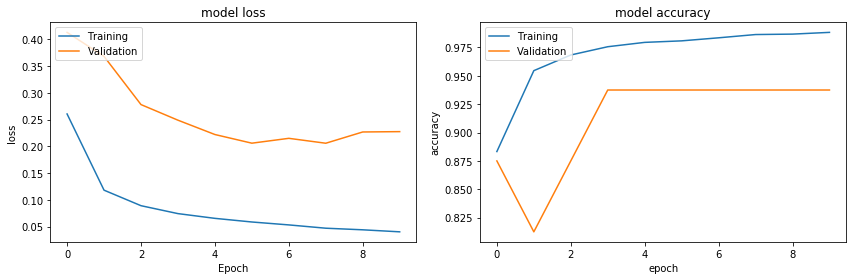

In [0]:
plot_learning_curves(history)

### Evaluating Model


In [0]:
# Choose the model with least validation loss

def get_best_model(history):
    idx = np.argmin(history.history['val_loss']) 
    print("Loading the best model")
    best_model_epoch = idx + 1
    best_model_val_loss = history.history['val_loss'][idx]
    best_model_val_acc = history.history['val_accuracy'][idx]
    return best_model_epoch, best_model_val_loss, best_model_val_acc


best_model_epoch, best_model_val_loss, best_model_val_acc = get_best_model(history)
print("epoch: {}, val_loss: {}, val_acc: {}".format(best_model_epoch, best_model_val_loss, best_model_val_acc))
best_model = model_name.format(
                epoch   =   best_model_epoch,
                val_loss=   round(best_model_val_loss, 2)
            )
best_model

Loading the best model
epoch: 8, val_loss: 0.20576098561286926, val_acc: 0.9375


'./data/output/models/2019-10-09_17-11-14/epoch_08-val_loss_0.21.hdf5'

In [0]:
print("Loading best_model: ", best_model)
try:
    model.load_weights(best_model)
except Exception as e:
    print("Fail to laod model. Error: ", e)
print("Loaded.")

Loading best_model:  ./data/output/models/2019-10-09_17-11-14/epoch_08-val_loss_0.21.hdf5
Loaded.


In [0]:
x_test, y_test = next(iter(test_dataset))
score = model.evaluate(x_test.numpy(), y_test.numpy(), verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 0.5621000360219907, Accuracy: 0.8108974099159241


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 76.98%
Recall        : 99.49%
F1-Score      : 86.80%
------------------------------------------------------------------------------------------





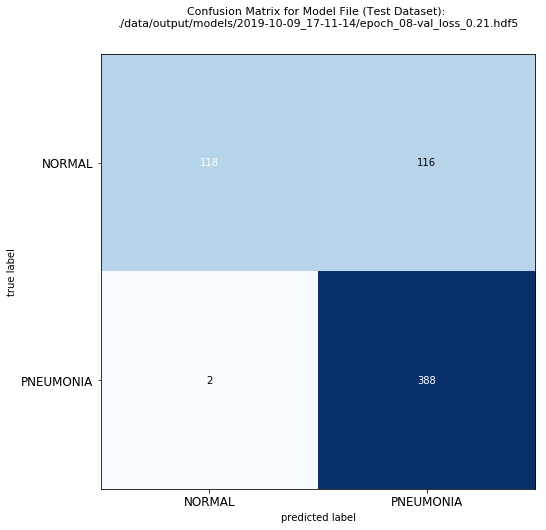




------------------------------------------------------------------------------------------
Report for Model File:  ./data/output/models/2019-10-09_17-11-14/epoch_08-val_loss_0.21.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      NORMAL       0.98      0.50      0.67       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624

------------------------------------------------------------------------------------------


In [0]:
# Confusion Matrix of the model

y_pred = model.predict(x_test.numpy())
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test.numpy(), axis = 1) 

confusion_matrix_file = output_figures_dir+"/confusion_matrix"
get_confusion_matrix(y_true, y_pred_classes, confusion_matrix_file, best_model)

### Fine Tuning
- Since dataset is small and different from pre-trained model's dataset
   
    - train some layers and leave some frozen
    - lower learning rate
    - increase epochs

In [0]:
pretrained_model.trainable = True
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
for idx, layer in enumerate(pretrained_model.layers):
    print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: True
layer 16: block5_conv2, trainable: True
layer 17: block5_conv3, trainable: True
layer 18: block5_pool, trainable: True


In [0]:
fine_tune_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax'),
])

FINE_TUNE_LEARNING_RATE = INITIAL_LEARNING_RATE / 10

optimizer   = tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE)
loss        = 'categorical_crossentropy'
metrics     = ['accuracy']

fine_tune_model.compile(
    loss=loss,     
    optimizer=optimizer, 
    metrics=metrics
)

fine_tune_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 16386     
Total params: 14,733,122
Trainable params: 7,096,834
Non-trainable params: 7,636,288
_________________________________________________________________


In [0]:
for idx, layer in enumerate(fine_tune_model.layers):
    print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))    

layer 0: vgg16, trainable: True
layer 1: batch_normalization_1, trainable: True
layer 2: flatten_1, trainable: True
layer 3: dense_1, trainable: True


In [0]:
reset_graph()
reset_callbacks()
fine_tune_model_name = curr_model_dir + "new_epoch_{epoch:02d}-val_loss_{val_loss:.2f}.hdf5"
callbacks = get_callbacks(model_name=fine_tune_model_name)

In [0]:
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS =  INITIAL_EPOCH + FINE_TUNE_EPOCHS

fine_tune_history = fine_tune_model.fit(
        train_dataset,
        class_weight = classweight,
        callbacks = callbacks,
        shuffle = True,
        validation_data = val_dataset,
        epochs = TOTAL_EPOCHS,
        verbose=1
    )


Epoch 1/20
82/82 [==============================] - 78s 946ms/step - loss: 0.1539 - accuracy: 0.9400 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
82/82 [==============================] - 77s 939ms/step - loss: 0.0537 - accuracy: 0.9820 - val_loss: 0.2985 - val_accuracy: 0.8750
Epoch 3/20
82/82 [==============================] - 77s 939ms/step - loss: 0.0326 - accuracy: 0.9921 - val_loss: 0.1873 - val_accuracy: 1.0000
Epoch 4/20
82/82 [==============================] - 75s 915ms/step - loss: 0.0197 - accuracy: 0.9965 - val_loss: 0.0991 - val_accuracy: 1.0000
Epoch 5/20
82/82 [==============================] - 74s 904ms/step - loss: 0.0135 - accuracy: 0.9985 - val_loss: 0.1540 - val_accuracy: 0.9375
Epoch 6/20
82/82 [==============================] - 76s 921ms/step - loss: 0.0098 - accuracy: 0.9992 - val_loss: 0.2170 - val_accuracy: 0.8750
Epoch 7/20
82/82 [==============================] - 76s 924ms/step - loss: 0.0069 - accuracy: 0.9998 - val_loss: 0.1568 - val_accuracy

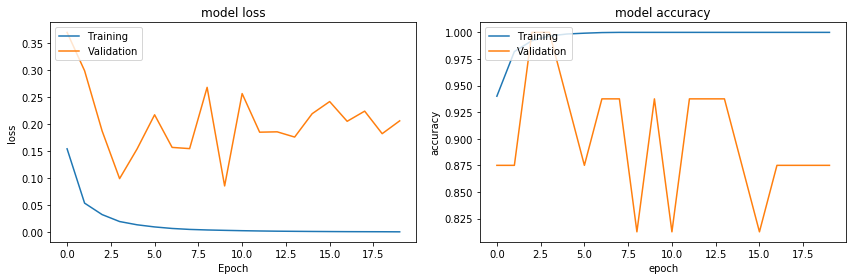

In [0]:
plot_learning_curves(fine_tune_history)

In [0]:

best_model_epoch, best_model_val_loss, best_model_val_acc = get_best_model(fine_tune_history)
print("epoch: {}, val_loss: {}, val_acc: {}".format(best_model_epoch, best_model_val_loss, best_model_val_acc))
best_fine_tune_model = fine_tune_model_name.format(
                epoch   =   best_model_epoch,
                val_loss=   round(best_model_val_loss, 2)
            )
best_fine_tune_model

Loading the best model
epoch: 10, val_loss: 0.08554095029830933, val_acc: 0.9375


'./data/output/models/2019-10-09_17-11-14/new_epoch_10-val_loss_0.09.hdf5'

In [0]:
print("Loading best_model: ", best_fine_tune_model)
try:
    fine_tune_model.load_weights(best_fine_tune_model)
except Exception as e:
    print("Fail to laod model. Error: ", e)
print("Loaded.")

Loading best_model:  ./data/output/models/2019-10-09_17-11-14/new_epoch_10-val_loss_0.09.hdf5
Loaded.


In [0]:
score = fine_tune_model.evaluate(x_test.numpy(), y_test.numpy(), verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 0.7214780113635919, Accuracy: 0.8237179517745972


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 78.23%
Recall        : 99.49%
F1-Score      : 87.58%
------------------------------------------------------------------------------------------





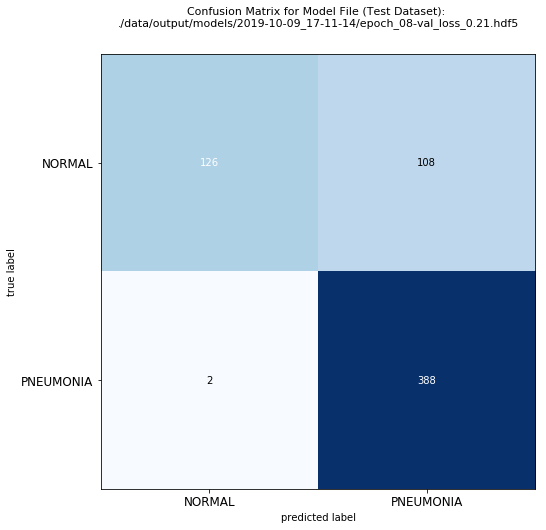




------------------------------------------------------------------------------------------
Report for Model File:  ./data/output/models/2019-10-09_17-11-14/new_epoch_10-val_loss_0.09.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      NORMAL       0.98      0.54      0.70       234
   PNEUMONIA       0.78      0.99      0.88       390

    accuracy                           0.82       624
   macro avg       0.88      0.77      0.79       624
weighted avg       0.86      0.82      0.81       624

------------------------------------------------------------------------------------------


In [0]:
y_pred = fine_tune_model.predict(x_test.numpy())
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test.numpy(), axis = 1) 

confusion_matrix_file = output_figures_dir+"/fine_tune_confusion_matrix"
get_confusion_matrix(y_true, y_pred_classes, confusion_matrix_file, best_fine_tune_model)

Note: 
- Reducing learning rate by a factor of 10

    - **Accuracy increase** by **1%**. **81.09%** -> **82.37%**
    - Pneumonia **precision increased** by **1%**
    - Normal **recall increase** by **4%**

### Visualizing Test Dataset Result

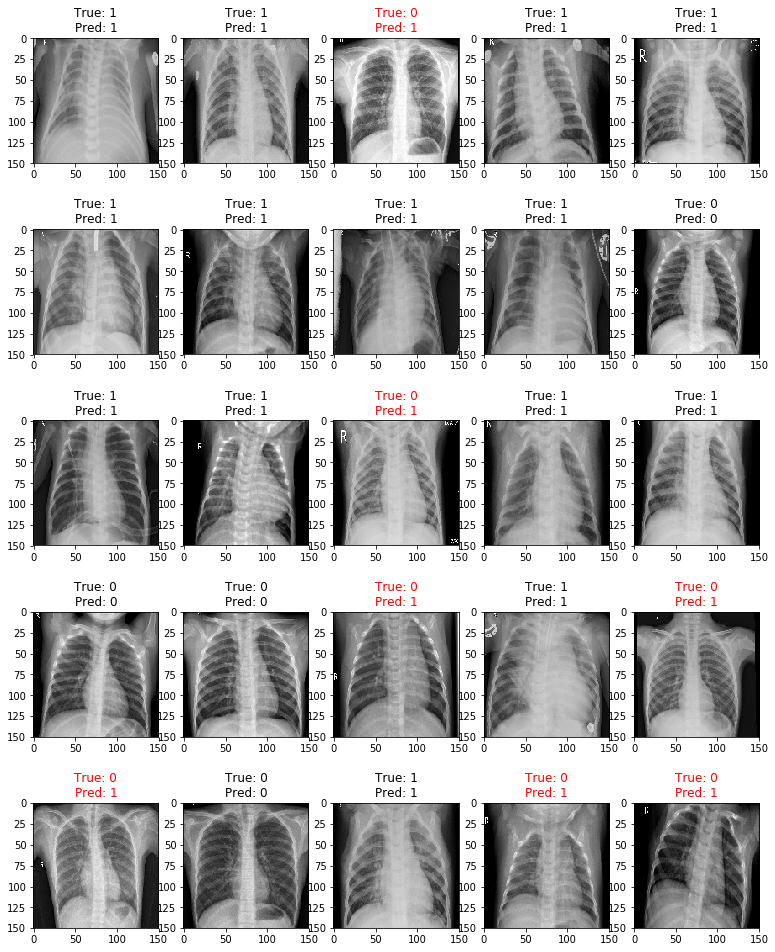

In [0]:
fig = plt.figure(figsize=(13,17))

for i in range(25):
    predicted = y_pred_classes[i]
    original = y_true[i]
    title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
    
    ax = fig.add_subplot(5, 5, i+1)

    if original == predicted:
        ax.set_title(title_text)
    else:
        ax.set_title(title_text, color='red')

    ax.imshow(x_test[i].numpy())

test_pred_result_file = output_figures_dir+"/fine_tune_test_prediction_results"
fig.savefig(test_pred_result_file, dpi=100)
plt.show()


### Last few words...
- Spent almost a week on this from begin to end.
- Faced a ton of issues such as: 

    - input dataset format issues
    - dealing with tensors
    - migrating to `Tensorflow 2` from `Tensorflow 1`
    - image preprocessing
    - dealing with insufficient new dataset
    - model configurations
    - model overfitting especially with `InceptionV3`. According to some Google searches: most probably the amount of new dataset isn't sufficient, therefore the massive weights that `InceptionV3` couldn't converge (?).
    - ...

- Things I could do differently if I have more time:

    - Hyperparameter tweaking using [`tensorboard's hparams`](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)
    - Utilize `tf.keras.preprocessing.image.ImageDataGenerator`?
